In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from numpy.core.numeric import _correlate_dispatcher
import pandas as pd
import scipy
from skmultilearn.model_selection import IterativeStratification
from utils.utils import makefolder_ifnotexists

class_names = ["MEL", "NV", "BKL"]  # remove the 9th "UNK" class
non_discriminative_feat_names = [
    "pigment_network", "globules", "negative_network", "streaks", "milia_like_cyst"]

discriminative_feat_names = [
    'pigmt_net_typical_includes_pseudonet',
    'dots_globs_reg',
    'negative_network',
    'strks_or_rad_strming',
    'MLCs_cloud',
    'granularity',
    'ker_plugs',
    'wobble',
    'scale',
    'blood',
    'atyp_net',
    'bld_vessels',
    'scarlike_regress',
    'ann_gran',
    'irreg_dots_globs',
    'blotch',
    'homog_tan_yellowish',
    'frambes_cerebriform_fernlike_pattern',
    'rough_covered_with_irreg_hyperkeratosis'
]




In [2]:
csv_dir = os.path.join('csv_files')
fold_save_dir = os.path.join('./data_folds/5foldTrainVal_featbalanced_no_lesion_id_leak')
makefolder_ifnotexists(fold_save_dir)

csv_file_my_train = os.path.join(csv_dir, 'Final_dataset_to_train.csv')

def add_dataset_class(source_df):
    source_df = source_df.replace({'dataset_class': r'.*?BCN.*\/?'}, {'dataset_class': 'BCN'}, regex=True)
    source_df = source_df.replace({'dataset_class': r'.*?HAM.*\/?'}, {'dataset_class': 'HAM'}, regex=True)
    source_df = source_df.replace({'dataset_class': r'.*?MSK.*\/?'}, {'dataset_class': 'MSK'}, regex=True)
    source_df = source_df.replace({'dataset_class':  r'.*?ISIC.*\/?'}, {'dataset_class': 'ISIC'}, regex=True)
    return source_df

In [3]:
isic_19_gt_meta_df = pd.read_csv('isic19_gt_meta.csv', skipinitialspace=True)
values = {'age_approx':0,	'anatom_site_general' : 'NA',	'lesion_id' : 'no_id',	'sex': 'unk'}
isic_19_gt_meta_df = isic_19_gt_meta_df.fillna(value=values)
isic_19_gt_meta_df.loc[(isic_19_gt_meta_df['lesion_id'] == 'no_id'), 'lesion_id'] = isic_19_gt_meta_df['image'][isic_19_gt_meta_df['lesion_id'] == 'no_id'] 
isic_19_gt_meta_df['dataset_class'] = isic_19_gt_meta_df['lesion_id']
unique_ids = isic_19_gt_meta_df.lesion_id.unique()

isic_19_gt_meta_df = add_dataset_class(isic_19_gt_meta_df)

In [4]:
isic_19_gt_meta_df_dset_percents = isic_19_gt_meta_df['dataset_class'].value_counts(normalize=True)


In [5]:
my_df = pd.read_csv(csv_file_my_train, skipinitialspace=True)
my_df = my_df.fillna(0)


In [6]:
my_df = my_df.merge(isic_19_gt_meta_df[['image', 'lesion_id']], how='inner', on='image')
my_df['dataset_class'] = my_df['lesion_id']

my_unique_ids = my_df.lesion_id.unique()

my_df = add_dataset_class(my_df)
my_df_dset_percents = my_df['dataset_class'].value_counts(normalize=True)

In [7]:
# my_df.to_csv('my_df_meta.csv')
def set_row_class(row):
    if row.MEL == 1:
        return 'MEL'
    if row.BKL == 1:
        return 'BKL'
    if row.NV == 1:
        return 'NV'

# create a column with class name
my_df['class'] = my_df.apply(lambda row: set_row_class(row), axis = 1)


In [8]:
# find rows with same lesion_id but different class names (i.e. diagnosis)
prob_df = my_df[my_df.groupby(['lesion_id'])['class'].transform('nunique') > 1]

# multiindexed df for extracting all rows with same lesion id
# e.g. heirarchical_df.xs(key="BCN_0001728", level="lesion_id")
heirarchical_df = my_df.set_index(["lesion_id", "image"])



In [9]:
data_df = my_df
class_dfs = {}
for class_ in class_names:
    class_dfs[class_] = data_df[data_df[class_] == 1]


In [10]:
n_splits = 5
order = 3
k_fold = IterativeStratification(n_splits=n_splits, order=order)

# classwise_fold = {}
train_final_folds = n_splits * [pd.DataFrame()]
val_final_folds = n_splits * [pd.DataFrame()]



In [11]:
for class_, class_df in class_dfs.items():
    stratification_on =  scipy.sparse.lil_matrix(class_df.loc[:,discriminative_feat_names].to_numpy())
    class_index_vals =  np.array(class_df.index.values.tolist()).transpose()
    fold_idx = 0
    for train_index, val_index in k_fold.split(class_df, stratification_on):

        train_diagfeat_discriminative_df  = class_df.iloc[train_index, :]
        val_diagfeat_discriminative_df = class_df.iloc[val_index, :]

        train_final_folds[fold_idx] = train_final_folds[fold_idx].append(train_diagfeat_discriminative_df)
        val_final_folds[fold_idx] =  val_final_folds[fold_idx].append(val_diagfeat_discriminative_df)
        fold_idx += 1


In [12]:
def get_value_counts(data_Series):
    value_list = list(data_Series.value_counts().values)
    if any(value_list):
        return value_list[0]
    else:
        return 0


In [13]:
# train and val sets for each fold. If a unique id is overrepresented in a set 
# then move all of that id to that set
my_df_lesion_id_cnts = my_df['lesion_id'].value_counts()
for fold_idx in range(n_splits):
    train_df = train_final_folds[fold_idx]
    val_df = val_final_folds[fold_idx]

    for lesion_id in list(my_df_lesion_id_cnts.keys()):
        train_lesion_id_df = train_df[train_df['lesion_id'] == lesion_id]
        train_lesion_id_cnts = get_value_counts(train_lesion_id_df['lesion_id'])
        
        val_lesion_id_df = val_df[val_df['lesion_id'] == lesion_id]
        val_lesion_id_cnts = get_value_counts(val_lesion_id_df['lesion_id'])
        if train_lesion_id_cnts <= val_lesion_id_cnts:
            # move rows to val dataset
            val_final_folds[fold_idx] = val_final_folds[fold_idx].append(train_lesion_id_df)
            train_final_folds[fold_idx] = train_final_folds[fold_idx].drop(train_lesion_id_df.index)

        else:
            # move rows to train dataset
            train_final_folds[fold_idx] = train_final_folds[fold_idx].append(val_lesion_id_df)
            val_final_folds[fold_idx] = val_final_folds[fold_idx].drop(val_lesion_id_df.index)



In [14]:
for idx in range(n_splits):
    train_fold_df = train_final_folds[idx]
    val_fold_df = val_final_folds[idx]

    bool_df = train_fold_df.isin({'lesion_id': list(val_fold_df['lesion_id'].unique()) })
    if bool_df['lesion_id'].sum() > 0:
        print('Data leak in fold {}'.format(idx))
    else:
        print('No data leak in {}'.format(idx))



No data leak in 0
No data leak in 1
No data leak in 2
No data leak in 3
No data leak in 4


In [15]:
for idx in range(n_splits):
    train_fold_df = train_final_folds[idx]
    val_fold_df = val_final_folds[idx]

    train_fold_df.to_csv(
        os.path.join(
            fold_save_dir,
            'train_featbalanced_{}fold{}.csv'.format(n_splits, idx)
        ),
        index=False, header=True
    )

    val_fold_df.to_csv(
        os.path.join(
            fold_save_dir,
            'val_featbalanced_{}fold{}.csv'.format(n_splits, idx)
        ),
        index=False, header=True
    )



In [17]:
sum_dict = {}

for idx in range(n_splits):
    train_fold_df = train_final_folds[idx]
    tr_s = train_fold_df.sum(numeric_only=True) 
    tr_s = tr_s[discriminative_feat_names] # / tr_s[discriminative_feat_names].sum()

    val_fold_df = val_final_folds[idx]
    vl_s = val_fold_df.sum(numeric_only=True)
    vl_s = vl_s[discriminative_feat_names] #/ vl_s[discriminative_feat_names].sum()

    sum_dict.update(
        {
            'tr_fld{}_feats'.format(idx): tr_s,
            'vl_fld{}_feats'.format(idx): vl_s,
        }
    )
    


In [18]:
hist_df = pd.DataFrame(sum_dict).fillna(0.0)
ax = hist_df.plot.area(stacked=False, figsize=(16, 6));

# We want to show all ticks...
ax.set_xticks(np.arange(len(discriminative_feat_names)));
# ... and label them with the respective list entries
ax.set_xticklabels(discriminative_feat_names);

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor");


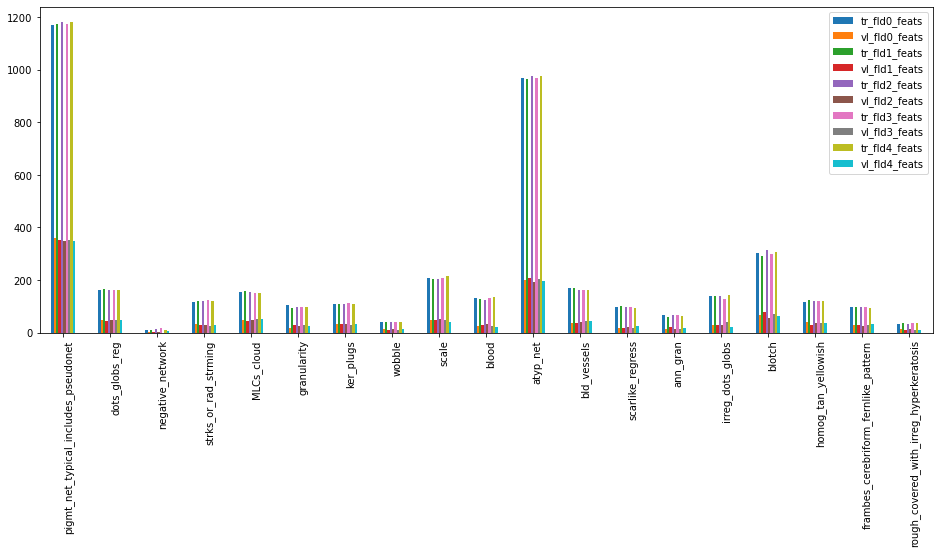

In [19]:
bar_df = pd.DataFrame(sum_dict).fillna(0.0)
ax = bar_df.plot.bar(figsize=(16, 6));

# We want to show all ticks...
ax.set_xticks(np.arange(len(discriminative_feat_names)));
# ... and label them with the respective list entries
ax.set_xticklabels(discriminative_feat_names);

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor");
